In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='3'

import diffusion_gosai_update
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra
import dataloader_gosai
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import oracle
from scipy.stats import pearsonr
import torch
from tqdm import tqdm
import diffusion_gosai_cfg
from utils import set_seed
set_seed(0, use_cuda=True)
plt.rcParams['figure.dpi'] = 200

%load_ext autoreload
%autoreload 2

/home/oz524/miniconda3/envs/sedd_drakes/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


=> Seed of the run set to 0


In [2]:
base_path = 'data/scratch/wangchy/seqft/'

In [3]:
# our model
CKPT_PATH = os.path.join(base_path, 'mdlm/reward_bp_results_final/finetuned.ckpt')
NUM_SAMPLE_BATCHES = 10
NUM_SAMPLES_PER_BATCH = 64

In [4]:
# reinitialize Hydra
GlobalHydra.instance().clear()

# Initialize Hydra and compose the configuration|
initialize(config_path="configs_gosai", job_name="load_model")
cfg = compose(config_name="config_gosai.yaml")
cfg.eval.checkpoint_path = CKPT_PATH

/tmp/ipykernel_3809711/1132405131.py:5: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="configs_gosai", job_name="load_model")


In [5]:
model = diffusion_gosai_update.Diffusion(cfg, eval=False).cuda()
model.load_state_dict(torch.load(cfg.eval.checkpoint_path))
model.eval()

Diffusion(
  (backbone): CNNModel(
    (linear): Conv1d(5, 128, kernel_size=(9,), stride=(1,), padding=(4,))
    (time_embedder): Sequential(
      (0): GaussianFourierProjection()
      (1): Linear(in_features=128, out_features=128, bias=True)
    )
    (convs): ModuleList(
      (0-7): 8 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(4,))
      (8-11): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
      (12-15): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
      (16-19): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    )
    (time_layers): ModuleList(
      (0-19): 20 x Dense(
        (dense): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (norms): ModuleList(
      (0-19): 20 x LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (final_conv): Sequential(
      (0): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (1): R

In [6]:
old_path = os.path.join(base_path, 'mdlm/outputs_gosai/pretrained.ckpt')
old_model = diffusion_gosai_update.Diffusion.load_from_checkpoint(old_path, config=cfg)
old_model.eval()

Diffusion(
  (backbone): CNNModel(
    (linear): Conv1d(5, 128, kernel_size=(9,), stride=(1,), padding=(4,))
    (time_embedder): Sequential(
      (0): GaussianFourierProjection()
      (1): Linear(in_features=128, out_features=128, bias=True)
    )
    (convs): ModuleList(
      (0-7): 8 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(4,))
      (8-11): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
      (12-15): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
      (16-19): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    )
    (time_layers): ModuleList(
      (0-19): 20 x Dense(
        (dense): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (norms): ModuleList(
      (0-19): 20 x LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (final_conv): Sequential(
      (0): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (1): R

In [7]:
zero_alpha_path = os.path.join(base_path, 'mdlm/reward_bp_results_final/zero_alpha.ckpt')
zero_alpha_model = diffusion_gosai_update.Diffusion(cfg).cuda()
zero_alpha_model.load_state_dict(torch.load(zero_alpha_path))
zero_alpha_model.eval()

Diffusion(
  (backbone): CNNModel(
    (linear): Conv1d(5, 128, kernel_size=(9,), stride=(1,), padding=(4,))
    (time_embedder): Sequential(
      (0): GaussianFourierProjection()
      (1): Linear(in_features=128, out_features=128, bias=True)
    )
    (convs): ModuleList(
      (0-7): 8 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(4,))
      (8-11): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
      (12-15): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
      (16-19): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    )
    (time_layers): ModuleList(
      (0-19): 20 x Dense(
        (dense): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (norms): ModuleList(
      (0-19): 20 x LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (final_conv): Sequential(
      (0): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (1): R

In [8]:
cfg_cfg = compose(config_name="config_gosai.yaml")
cfg_cfg.model.cls_free_guidance=True
cfg_cfg.model.cls_free_weight=10
cfg_cfg.model.cls_free_prob=0.1
cfg_path = os.path.join(base_path, 'mdlm/outputs_gosai/cfg.ckpt')
cfg_cfg.eval.checkpoint_path = cfg_path
cfg_model = diffusion_gosai_cfg.Diffusion(cfg_cfg, eval=False).cuda()
cfg_model.load_state_dict(torch.load(cfg_cfg.eval.checkpoint_path)['state_dict'])
cfg_model.eval()

Diffusion(
  (backbone): CNNModel(
    (linear): Conv1d(5, 128, kernel_size=(9,), stride=(1,), padding=(4,))
    (time_embedder): Sequential(
      (0): GaussianFourierProjection()
      (1): Linear(in_features=128, out_features=128, bias=True)
    )
    (convs): ModuleList(
      (0-7): 8 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(4,))
      (8-11): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
      (12-15): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
      (16-19): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    )
    (time_layers): ModuleList(
      (0-19): 20 x Dense(
        (dense): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (norms): ModuleList(
      (0-19): 20 x LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (final_conv): Sequential(
      (0): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (1): R

In [9]:
_path_n_kl = 'mdlm/reward_bp_results_final/finetuned_sepo_kl_gf.ckpt'
my_model_path_kl = os.path.join(base_path,_path_n_kl)
my_model_kl = diffusion_gosai_update.Diffusion(cfg, eval=False).cuda()
my_model_kl.load_state_dict(torch.load(my_model_path_kl))
my_model_kl.eval()

Diffusion(
  (backbone): CNNModel(
    (linear): Conv1d(5, 128, kernel_size=(9,), stride=(1,), padding=(4,))
    (time_embedder): Sequential(
      (0): GaussianFourierProjection()
      (1): Linear(in_features=128, out_features=128, bias=True)
    )
    (convs): ModuleList(
      (0-7): 8 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(4,))
      (8-11): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
      (12-15): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
      (16-19): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    )
    (time_layers): ModuleList(
      (0-19): 20 x Dense(
        (dense): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (norms): ModuleList(
      (0-19): 20 x LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (final_conv): Sequential(
      (0): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (1): R

In [10]:
_path_n = 'mdlm/reward_bp_results_final/finetuned_sepo_kl.ckpt'
my_model_path = os.path.join(base_path,_path_n)
my_model = diffusion_gosai_update.Diffusion(cfg, eval=False).cuda()
my_model.load_state_dict(torch.load(my_model_path))
my_model.eval()

Diffusion(
  (backbone): CNNModel(
    (linear): Conv1d(5, 128, kernel_size=(9,), stride=(1,), padding=(4,))
    (time_embedder): Sequential(
      (0): GaussianFourierProjection()
      (1): Linear(in_features=128, out_features=128, bias=True)
    )
    (convs): ModuleList(
      (0-7): 8 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(4,))
      (8-11): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
      (12-15): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
      (16-19): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    )
    (time_layers): ModuleList(
      (0-19): 20 x Dense(
        (dense): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (norms): ModuleList(
      (0-19): 20 x LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (final_conv): Sequential(
      (0): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (1): R

### Sample from the generative model

In [11]:
all_detoeknized_samples_my_model_kl = []
all_raw_samples_my_model_kl = []
for _ in tqdm(range(NUM_SAMPLE_BATCHES)):
    samples = my_model_kl._sample(eval_sp_size=NUM_SAMPLES_PER_BATCH)
    all_raw_samples_my_model_kl.append(samples)
    detokenized_samples = dataloader_gosai.batch_dna_detokenize(samples.detach().cpu().numpy())
    all_detoeknized_samples_my_model_kl.extend(detokenized_samples)
all_raw_samples_my_model_kl = torch.concat(all_raw_samples_my_model_kl)
#model_logl_my_model_kl = old_model.get_likelihood(all_raw_samples_my_model_kl, num_steps=128, n_samples=1)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:27<00:00,  2.78s/it]


In [12]:
all_detoeknized_samples_my_model = []
all_raw_samples_my_model = []
for _ in tqdm(range(NUM_SAMPLE_BATCHES)):
    samples = my_model._sample(eval_sp_size=NUM_SAMPLES_PER_BATCH)
    all_raw_samples_my_model.append(samples)
    detokenized_samples = dataloader_gosai.batch_dna_detokenize(samples.detach().cpu().numpy())
    all_detoeknized_samples_my_model.extend(detokenized_samples)
all_raw_samples_my_model = torch.concat(all_raw_samples_my_model)
#model_logl_my_model = old_model.get_likelihood(all_raw_samples_my_model, num_steps=128, n_samples=1)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:28<00:00,  2.81s/it]


In [13]:
all_detoeknized_samples = []
all_raw_samples = []
for _ in tqdm(range(NUM_SAMPLE_BATCHES)):
    samples = model._sample(eval_sp_size=NUM_SAMPLES_PER_BATCH)
    all_raw_samples.append(samples)
    detokenized_samples = dataloader_gosai.batch_dna_detokenize(samples.detach().cpu().numpy())
    all_detoeknized_samples.extend(detokenized_samples)
all_raw_samples = torch.concat(all_raw_samples)
#model_logl = old_model.get_likelihood(all_raw_samples, num_steps=128, n_samples=1)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:28<00:00,  2.86s/it]


In [14]:
reward_model_bs = oracle.get_gosai_oracle(mode='train')
reward_model_bs.eval()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dofelltv. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8


LightningModel(
  (model): EnformerPretrainedModel(
    (embedding): EnformerTrunk(
      (conv_tower): EnformerConvTower(
        (blocks): ModuleList(
          (0): Sequential(
            (0): Conv1d(4, 768, kernel_size=(15,), stride=(1,), padding=same)
            (1): ConvBlock(
              (norm): Norm(
                (layer): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (conv): Conv1d(768, 768, kernel_size=(1,), stride=(1,), padding=same)
              (act): Activation(
                (layer): GELU()
              )
              (pool): Pool(
                (layer): AttentionPool(
                  (pool_fn): Rearrange('b d (n p) -> b d n p', p=2)
                  (to_attn_logits): Conv2d(768, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
                )
              )
              (dropout): Dropout(
                (layer): Identity()
              )
              (channel_transform): ChannelT

In [15]:
tds_all_detoeknized_samples = []
tds_all_raw_samples = []
for _ in tqdm(range(NUM_SAMPLE_BATCHES)):
    samples = old_model.controlled_sample_TDS(reward_model=reward_model_bs, alpha=0.5, guidance_scale=1000, eval_sp_size=NUM_SAMPLES_PER_BATCH)
    tds_all_raw_samples.append(samples)
    detokenized_samples = dataloader_gosai.batch_dna_detokenize(samples.detach().cpu().numpy())
    tds_all_detoeknized_samples.extend(detokenized_samples)
tds_all_raw_samples = torch.concat(tds_all_raw_samples)
#tds_model_logl = old_model.get_likelihood(tds_all_raw_samples, num_steps=128, n_samples=1)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [10:25<00:00, 62.53s/it]


In [16]:
cg_all_detoeknized_samples = []
cg_all_raw_samples = []
for _ in tqdm(range(NUM_SAMPLE_BATCHES)):
    samples = old_model.controlled_sample_CG(reward_model=reward_model_bs, guidance_scale=300000, eval_sp_size=NUM_SAMPLES_PER_BATCH)
    cg_all_raw_samples.append(samples)
    detokenized_samples = dataloader_gosai.batch_dna_detokenize(samples.detach().cpu().numpy())
    cg_all_detoeknized_samples.extend(detokenized_samples)
cg_all_raw_samples = torch.concat(cg_all_raw_samples)
#cg_model_logl = old_model.get_likelihood(cg_all_raw_samples, num_steps=128, n_samples=1)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [06:06<00:00, 36.67s/it]


In [17]:
old_all_detoeknized_samples = []
old_all_raw_samples = []
for _ in tqdm(range(NUM_SAMPLE_BATCHES)):
    samples = old_model._sample(eval_sp_size=NUM_SAMPLES_PER_BATCH)
    old_all_raw_samples.append(samples)
    detokenized_samples = dataloader_gosai.batch_dna_detokenize(samples.detach().cpu().numpy())
    old_all_detoeknized_samples.extend(detokenized_samples)
old_all_raw_samples = torch.concat(old_all_raw_samples)
#old_model_logl = old_model.get_likelihood(old_all_raw_samples, num_steps=128, n_samples=1)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


In [18]:
smc_all_detoeknized_samples = []
smc_all_raw_samples = []
for _ in tqdm(range(NUM_SAMPLE_BATCHES)):
    samples = old_model.controlled_sample_SMC(reward_model=reward_model_bs, alpha=0.5, eval_sp_size=NUM_SAMPLES_PER_BATCH)
    smc_all_raw_samples.append(samples)
    detokenized_samples = dataloader_gosai.batch_dna_detokenize(samples.detach().cpu().numpy())
    smc_all_detoeknized_samples.extend(detokenized_samples)
smc_all_raw_samples = torch.concat(smc_all_raw_samples)
#smc_model_logl = old_model.get_likelihood(smc_all_raw_samples, num_steps=128, n_samples=1)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [04:45<00:00, 28.52s/it]


In [19]:
zero_alpha_all_detoeknized_samples = []
zero_alpha_all_raw_samples = []
for _ in tqdm(range(NUM_SAMPLE_BATCHES)):
    samples = zero_alpha_model._sample(eval_sp_size=NUM_SAMPLES_PER_BATCH)
    zero_alpha_all_raw_samples.append(samples)
    detokenized_samples = dataloader_gosai.batch_dna_detokenize(samples.detach().cpu().numpy())
    zero_alpha_all_detoeknized_samples.extend(detokenized_samples)
zero_alpha_all_raw_samples = torch.concat(zero_alpha_all_raw_samples)
#zero_alpha_model_logl = old_model.get_likelihood(zero_alpha_all_raw_samples, num_steps=128, n_samples=1)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:30<00:00,  3.05s/it]


In [20]:
cfg_all_detoeknized_samples = []
cfg_all_raw_samples = []
for _ in tqdm(range(NUM_SAMPLE_BATCHES)):
    samples = cfg_model._sample(eval_sp_size=NUM_SAMPLES_PER_BATCH, w=10)
    cfg_all_raw_samples.append(samples)
    detokenized_samples = dataloader_gosai.batch_dna_detokenize(samples.detach().cpu().numpy())
    cfg_all_detoeknized_samples.extend(detokenized_samples)
cfg_all_raw_samples = torch.concat(cfg_all_raw_samples)
#cfg_model_logl = old_model.get_likelihood(cfg_all_raw_samples, num_steps=128, n_samples=1)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:04<00:00,  6.50s/it]


### Pred-Activity based on Eval Oracle

In [21]:
# Calculate the predictions of the oracle model on the generated sequences
generated_preds = oracle.cal_gosai_pred_new(all_detoeknized_samples, mode='eval')
old_generated_preds = oracle.cal_gosai_pred_new(old_all_detoeknized_samples, mode='eval')
zero_alpha_preds = oracle.cal_gosai_pred_new(zero_alpha_all_detoeknized_samples, mode='eval')
cfg_preds = oracle.cal_gosai_pred_new(cfg_all_detoeknized_samples, mode='eval')
cg_preds = oracle.cal_gosai_pred_new(cg_all_detoeknized_samples, mode='eval')
smc_preds = oracle.cal_gosai_pred_new(smc_all_detoeknized_samples, mode='eval')
tds_preds = oracle.cal_gosai_pred_new(tds_all_detoeknized_samples, mode='eval')
generated_preds_my_model = oracle.cal_gosai_pred_new(all_detoeknized_samples_my_model, mode='eval')
generated_preds_my_model_kl = oracle.cal_gosai_pred_new(all_detoeknized_samples_my_model_kl, mode='eval')

wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.9
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wa

In [22]:
compare = np.concatenate((old_generated_preds[:,0],
                            zero_alpha_preds[:,0],
                            generated_preds[:,0],
                            cfg_preds[:,0],
                            cg_preds[:,0],
                            smc_preds[:,0],
                            tds_preds[:,0],
                            generated_preds_my_model[:,0],
                            generated_preds_my_model_kl[:,0]), axis= 0)

/tmp/ipykernel_3809711/1008054668.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_3809711/1008054668.py:45: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.1`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(


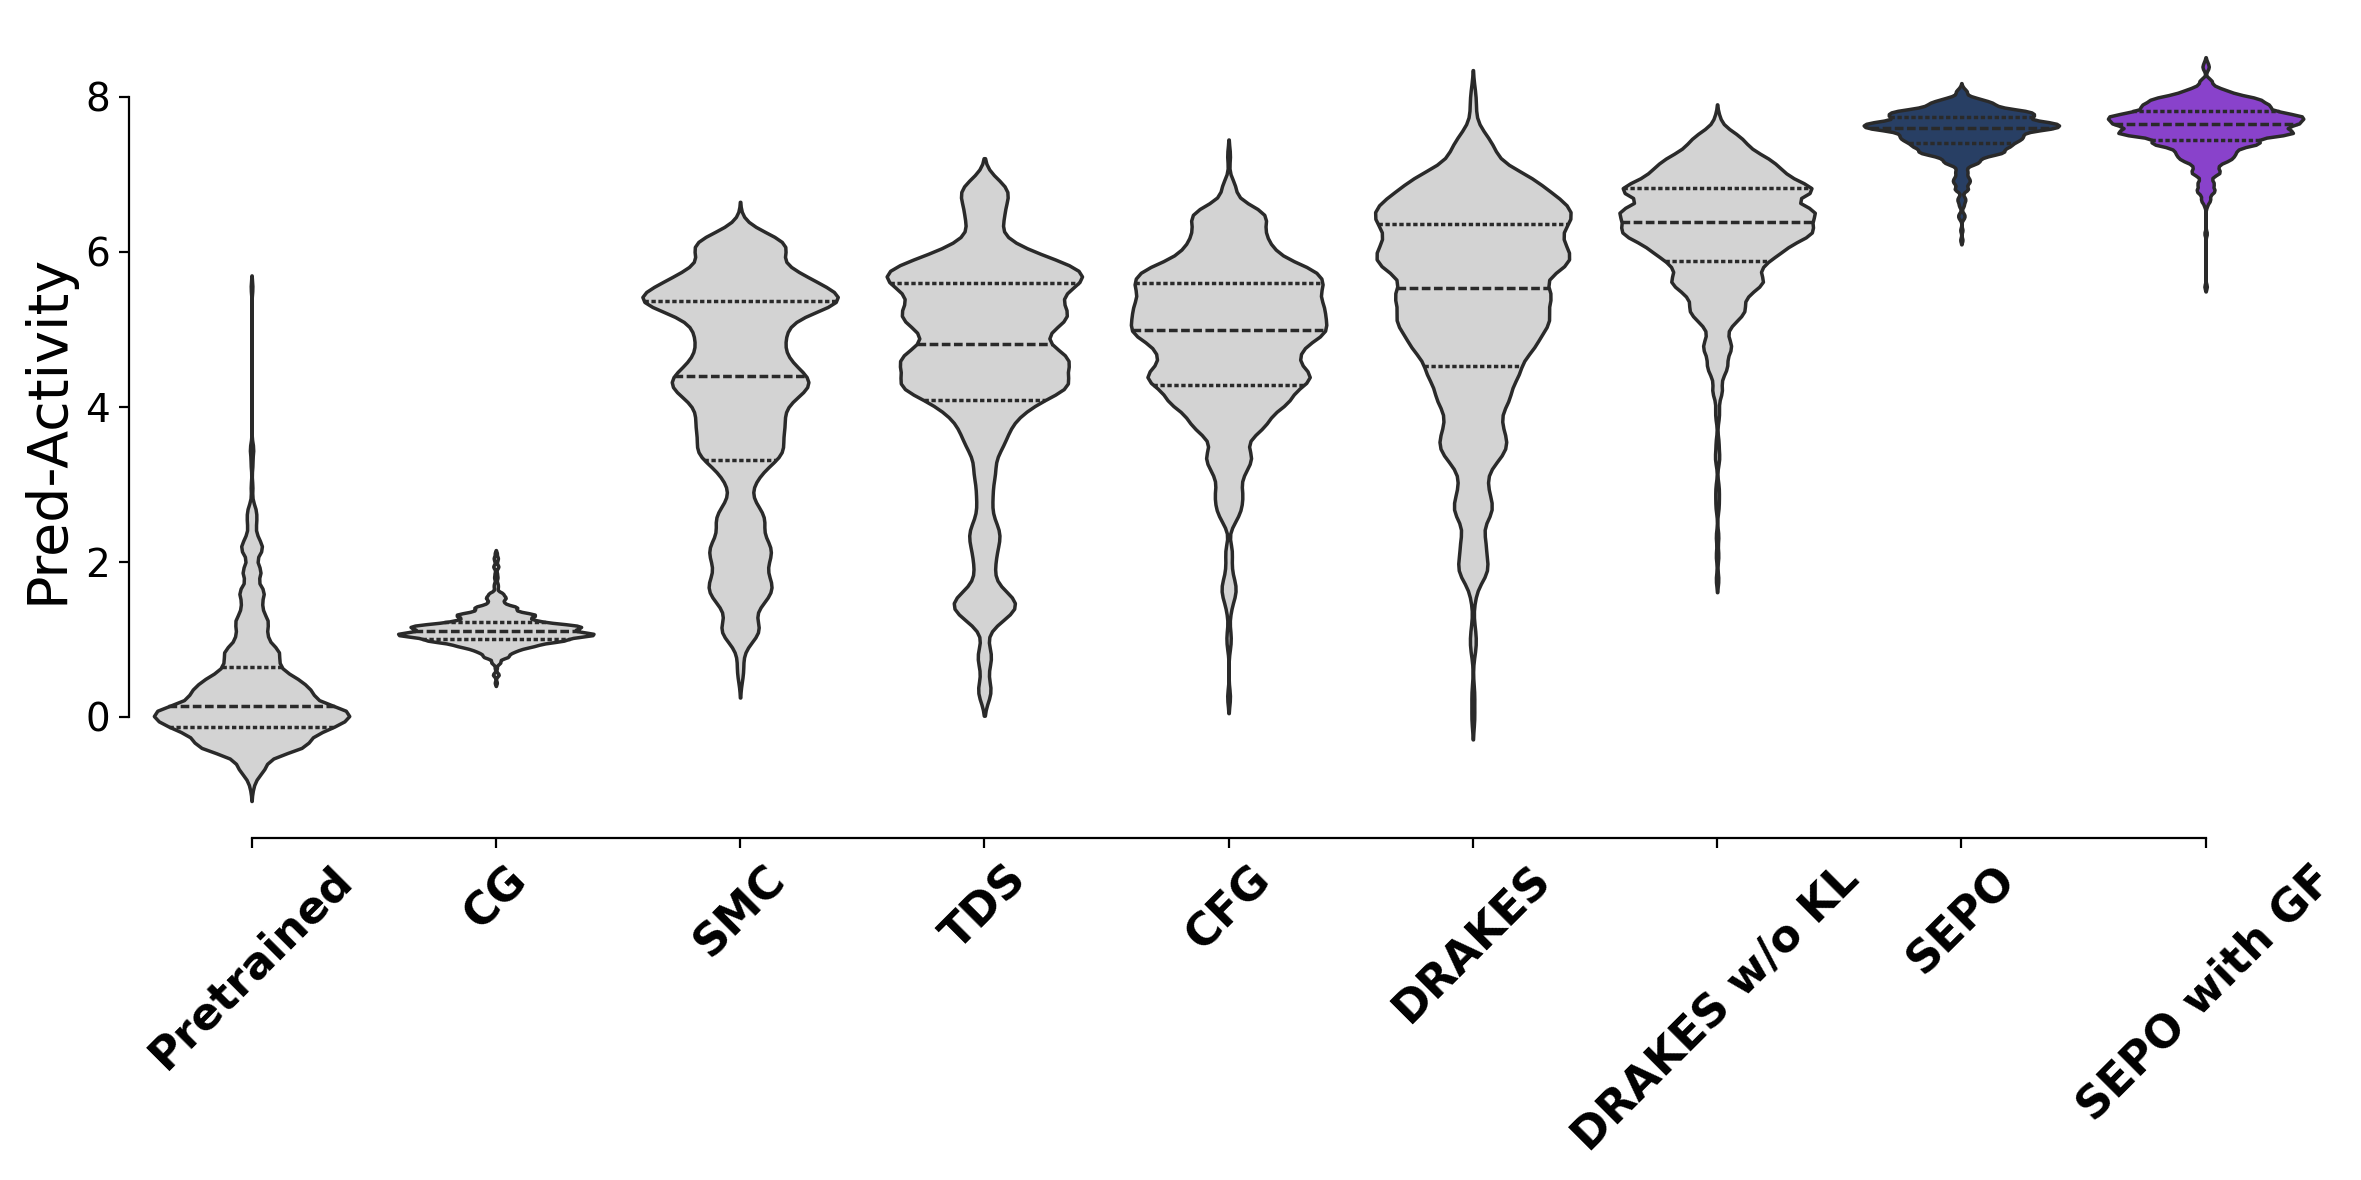

In [23]:
import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Example: Replace these with your real arrays
model_arrays = [
    old_generated_preds[:, 0],          # Pretrained
    cg_preds[:, 0],                     # CG
    smc_preds[:, 0],                    # SMC
    tds_preds[:, 0],                    # TDS
    cfg_preds[:, 0],                    # CFG
    generated_preds[:, 0],              # DRAKES
    zero_alpha_preds[:, 0],             # DRAKES w/o KL
    generated_preds_my_model[:, 0],     # SEPO
    generated_preds_my_model_kl[:, 0],  # SEPO w GF
]

model_names = [
    'Pretrained', 
    'CG', 
    'SMC', 
    'TDS', 
    'CFG', 
    'DRAKES', 
    'DRAKES w/o KL', 
    'SEPO', 
    'SEPO with GF'
]

# Flatten data
data = np.concatenate(model_arrays)
labels = sum([[name] * len(arr) for name, arr in zip(model_names, model_arrays)], [])

# Create DataFrame
df = pd.DataFrame({'Prediction': data, 'Model': labels})

# Highlight Palette
highlight_palette = ['#d3d3d3'] * len(model_names)
highlight_palette[model_names.index('SEPO')] = '#1E3C6E'        # Highlight SEPO
highlight_palette[model_names.index('SEPO with GF')] = '#8A2BE2'  # Highlight SEPO with GF

# Plot
plt.figure(figsize=(12, 6))
sns.violinplot(
    x='Model', 
    y='Prediction', 
    data=df, 
    inner='quartile',            
    palette=highlight_palette, 
    bw=0.1                       
)

# Axis Formatting
plt.ylabel('Pred-Activity', fontsize=20)
plt.xticks(rotation=45, fontsize=16, fontweight='bold')
plt.yticks(fontsize=14)
plt.grid(False)
plt.xlabel('')

# Detach Axes (Top and Right Spines)
sns.despine(trim=True)  

plt.tight_layout()
#plt.savefig('model_predictions.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [24]:
np.median(compare.reshape(-1, 640), axis=-1)

array([0.13497943, 6.385295  , 5.53473   , 4.991597  , 1.1051726 ,
       4.394068  , 4.8095818 , 7.592858  , 7.6454525 ], dtype=float32)

### ATAC-Acc

In [25]:
generated_preds_atac = oracle.cal_atac_pred_new(all_detoeknized_samples)
old_generated_preds_atac = oracle.cal_atac_pred_new(old_all_detoeknized_samples)
zero_alpha_preds_atac = oracle.cal_atac_pred_new(zero_alpha_all_detoeknized_samples)
cfg_preds_atac = oracle.cal_atac_pred_new(cfg_all_detoeknized_samples)
cg_preds_atac = oracle.cal_atac_pred_new(cg_all_detoeknized_samples)
smc_preds_atac = oracle.cal_atac_pred_new(smc_all_detoeknized_samples)
tds_preds_atac = oracle.cal_atac_pred_new(tds_all_detoeknized_samples)
generated_preds_atac_my_model_kl = oracle.cal_atac_pred_new(all_detoeknized_samples_my_model_kl)
generated_preds_atac_my_model = oracle.cal_atac_pred_new(all_detoeknized_samples_my_model)

wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wa

In [26]:
compare_ = np.concatenate((old_generated_preds_atac[:,1],
                            zero_alpha_preds_atac[:,1],
                            generated_preds_atac[:,1],
                            cfg_preds_atac[:,1],
                            cg_preds_atac[:,1],
                            smc_preds_atac[:,1],
                            tds_preds_atac[:,1],
                            generated_preds_atac_my_model_kl[:,1],
                            generated_preds_atac_my_model[:,1]), axis= 0)

/tmp/ipykernel_3809711/1225600843.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_3809711/1225600843.py:45: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.1`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(


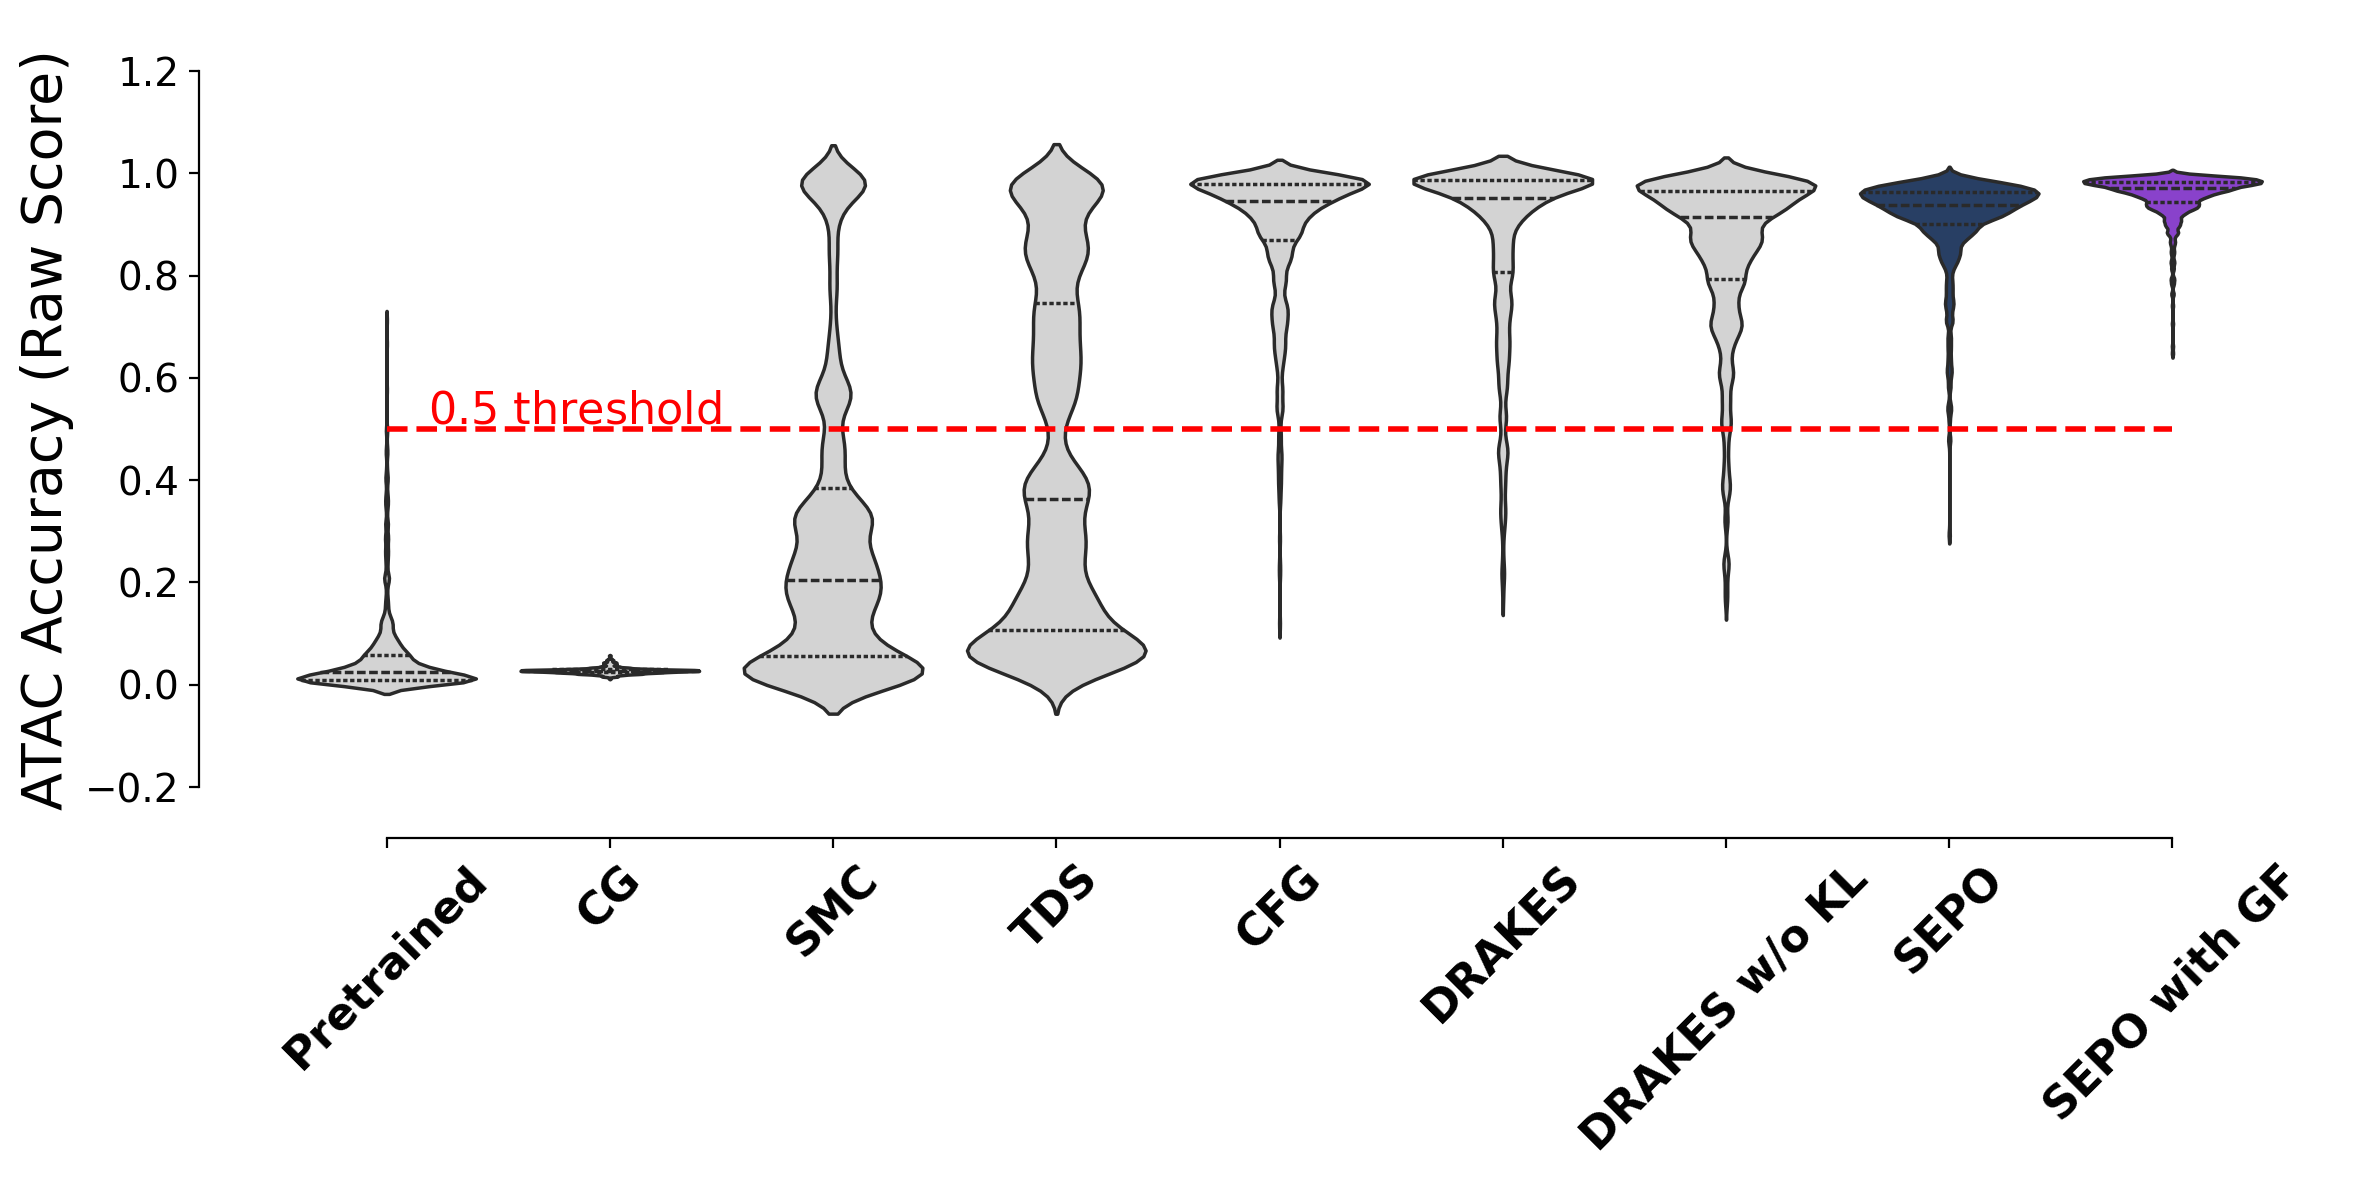

In [57]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Example: Replace these with your real arrays
model_arrays = [
    old_generated_preds_atac[:, 0],          # Pretrained
    cg_preds_atac[:, 0],                     # CG
    smc_preds_atac[:, 0],                    # SMC
    tds_preds_atac[:, 0],                    # TDS
    cfg_preds_atac[:, 0],                    # CFG
    generated_preds_atac[:, 0],               # DRAKES
    zero_alpha_preds_atac[:, 0],              # DRAKES w/o KL
    generated_preds_atac_my_model[:, 0],      # SEPO
    generated_preds_atac_my_model_kl[:, 0],   # SEPO with GF
]

model_names = [
    'Pretrained', 
    'CG', 
    'SMC', 
    'TDS', 
    'CFG', 
    'DRAKES', 
    'DRAKES w/o KL', 
    'SEPO', 
    'SEPO with GF'
]

# Flatten data without scaling to percentage
data = np.concatenate(model_arrays)
labels = sum([[name] * len(arr) for name, arr in zip(model_names, model_arrays)], [])

# Create DataFrame
df = pd.DataFrame({'Prediction': data, 'Model': labels})

# Highlight Palette: Gray for others, custom colors for SEPO models
highlight_palette = ['#d3d3d3'] * len(model_names)
highlight_palette[model_names.index('SEPO')] = '#1E3C6E'        # Highlight SEPO
highlight_palette[model_names.index('SEPO with GF')] = '#8A2BE2'  # Highlight SEPO with GF

# Plot
plt.figure(figsize=(12, 6))
sns.violinplot(
    x='Model', 
    y='Prediction', 
    data=df, 
    inner='quartile',      
    palette=highlight_palette, 
    bw=0.1                  
)

# Get the correct positions for the x-axis limits directly from the plot
ax = plt.gca()
positions = np.arange(len(model_names))

# Draw the horizontal line only between the first and last model positions
plt.hlines(
    y=0.5, xmin=positions[0], xmax=positions[-1], 
    colors='red', linestyles='--', linewidth=2
)

# Add annotation
plt.text(
    x=1.5,  # Position it near the last model
    y=0.51,                  # Slightly above the line to avoid overlap
    s=r"$0.5$ threshold",
    color='red',
    fontsize=16,
    ha='right'
)

# Axis Formatting
plt.ylabel('ATAC Accuracy (Raw Score)', fontsize=20)
plt.xticks(rotation=45, fontsize=16, fontweight='bold')
plt.yticks(fontsize=14)
plt.grid(False)
plt.xlabel('')
plt.ylim(-0.3, 1.3)

# Clean style
plt.grid(False)
sns.despine(trim=True)

plt.tight_layout()
plt.savefig('atac_model_predictions.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [58]:
(old_generated_preds_atac[:,0]>0.5).sum()/640

0.0046875

In [59]:
(generated_preds_atac[:,0]>0.5).sum()/640

0.93125

In [60]:
(zero_alpha_preds_atac[:,0]>0.5).sum()/640

0.9515625

In [61]:
(cfg_preds_atac[:,0]>0.5).sum()/640

0.9703125

In [62]:
(cg_preds_atac[:,0]>0.5).sum()/640

0.0

In [63]:
(smc_preds_atac[:,0]>0.5).sum()/640

0.2046875

In [64]:
(tds_preds_atac[:,0]>0.5).sum()/640

0.409375

In [65]:
(generated_preds_atac_my_model[:,0]>0.5).sum()/640

0.9953125

In [66]:
(generated_preds_atac_my_model_kl[:,0]>0.5).sum()/640

1.0